<a href="https://colab.research.google.com/github/nmoisseeva/mv_ozone/blob/main/task1_ozone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
#Nov 22, 2023

#This script looks at trends in hourly ozone

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
import seaborn as sns

mpl.rcParams['figure.dpi'] = 200



### INPUT ###

# ap2014_path = '/content/drive/MyDrive/colab/consulting/mv/Data Package 1of2.xlsx'
# ap2024_path = '/content/drive/MyDrive/colab/consulting/mv/Data Package 2of2.xlsx'
ap2014_path = '/content/drive/MyDrive/colab/consulting/mv/O3_2002-2012.xlsx'
ap2024_path = '/content/drive/MyDrive/colab/consulting/mv/O3_2013-2023.xlsx'


stations = ['T012','T031']
# stations =
quantiles = [0.5, 0.75, 0.95]

### end of input ###




In [3]:
#import data
ap2014 = pd.read_excel(ap2014_path,\
                      header=2, index_col=0, skiprows = lambda x: x in [3, 4], \
                      #  usecols=[0,6,33], names=['datetime']+stations,\
                       na_values=['NoData','Calib','<Samp','Zero','Down','InVld','Span','RS232'])


In [4]:
ap2024 = pd.read_excel(ap2024_path,\
          header=2, index_col=0, skiprows = lambda x: x in [3, 4], \
                      #  usecols=[0,6,32], names=['datetime']+stations,\
                       na_values=['NoData','Calib','<Samp','Zero','Down','InVld','Span','RS232'])

In [58]:
#-----optional: check for random missing data strings-------
# pd.to_numeric(ap2024.T031)

In [5]:
#convert index to datetime and data to float
ap2014.index = pd.to_datetime(ap2014.index)
ap2014.convert_dtypes()
# ap2014['jday'] = ap2014.index.day_of_year

ap2024.index = pd.to_datetime(ap2024.index)
ap2024.convert_dtypes()
# ap2024['jday'] = ap2024.index.day_of_year


,T012,T031
Date & Time,,
2013-01-01 00:00:00,2.3,0.1
2013-01-01 01:00:00,1.3,0.2
2013-01-01 02:00:00,1.5,0.2
2013-01-01 03:00:00,<NA>,1.4
2013-01-01 04:00:00,9.0,0.5
...,...,...
2023-12-31 19:00:00,<NA>,<NA>
2023-12-31 20:00:00,<NA>,<NA>
2023-12-31 21:00:00,<NA>,<NA>


In [187]:
#group by year
grp2014 = ap2014.groupby(ap2014.index.year)
grp2024 = ap2024.groupby(ap2024.index.year)


#create 8h avareges
ap8h2014 = ap2014.rolling(8, min_periods=6).mean()
ap8h2024 = ap2024.rolling(8, min_periods=6).mean()
grp8h2014 = ap8h2014.groupby(ap8h2014.index.year)
grp8h2024 = ap8h2024.groupby(ap8h2024.index.year)

In [ ]:
#assemble data, do grouping and averaging
ozone_1h = pd.concat([ap2014, ap2024])
grp_1h = ozone_1h.groupby(ozone_1h.index.year)

ozone_8h = ozone_1h.rolling(8, min_periods=6).mean()
grp_8h = ozone_8h.groupby(ozone_8h.index.year)

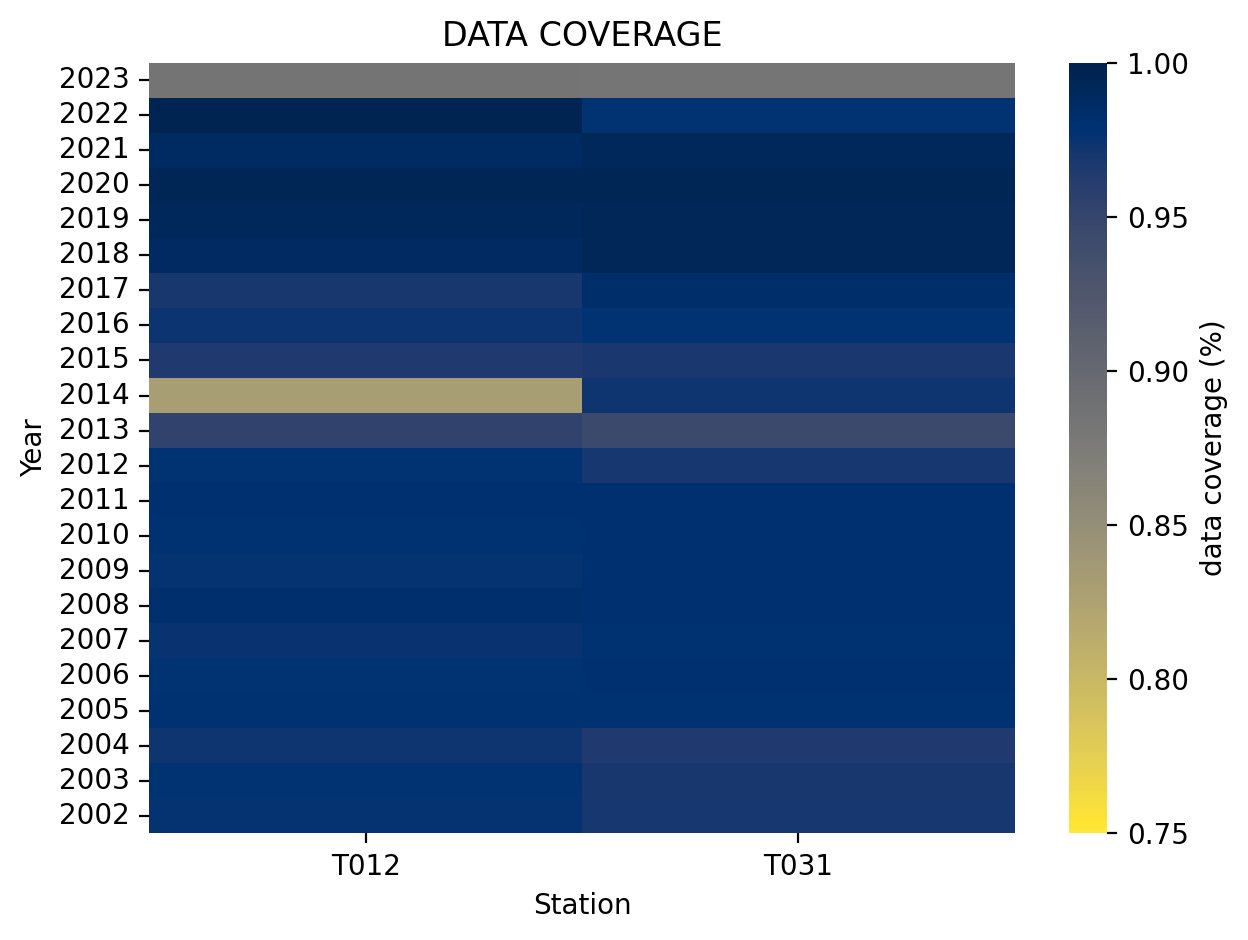

In [222]:
#look at how complete the data is
plt.figure()
ax = plt.gca()
sns.heatmap(grp_1h.count()/8760, vmin=0.75, vmax=1,cmap='cividis_r',cbar_kws={'label': 'data coverage (%)'})
ax.set(ylabel='Year', xlabel='Station', title='DATA COVERAGE')
ax.invert_yaxis()
plt.tight_layout()

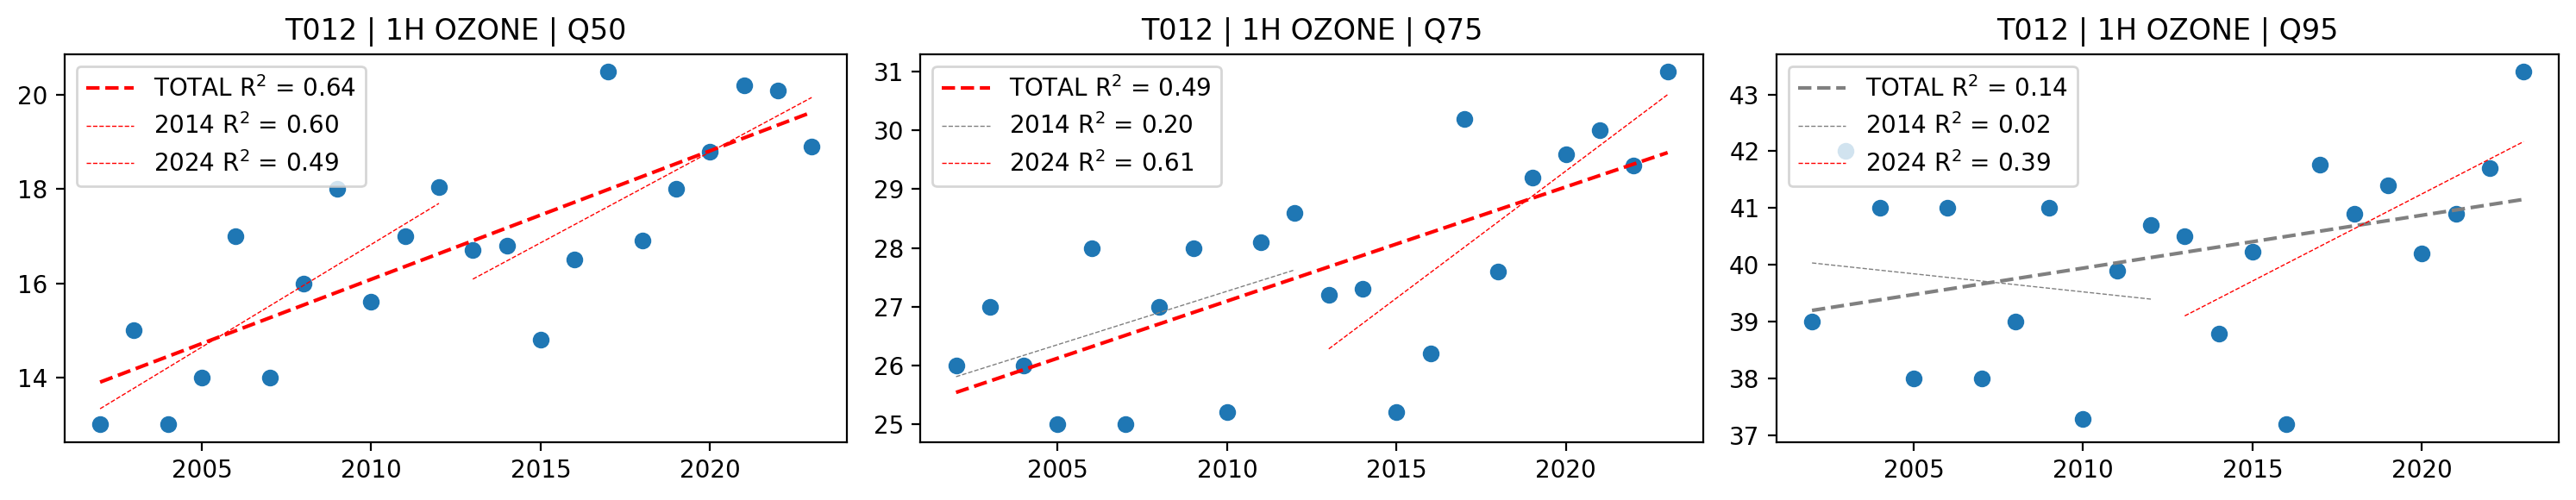

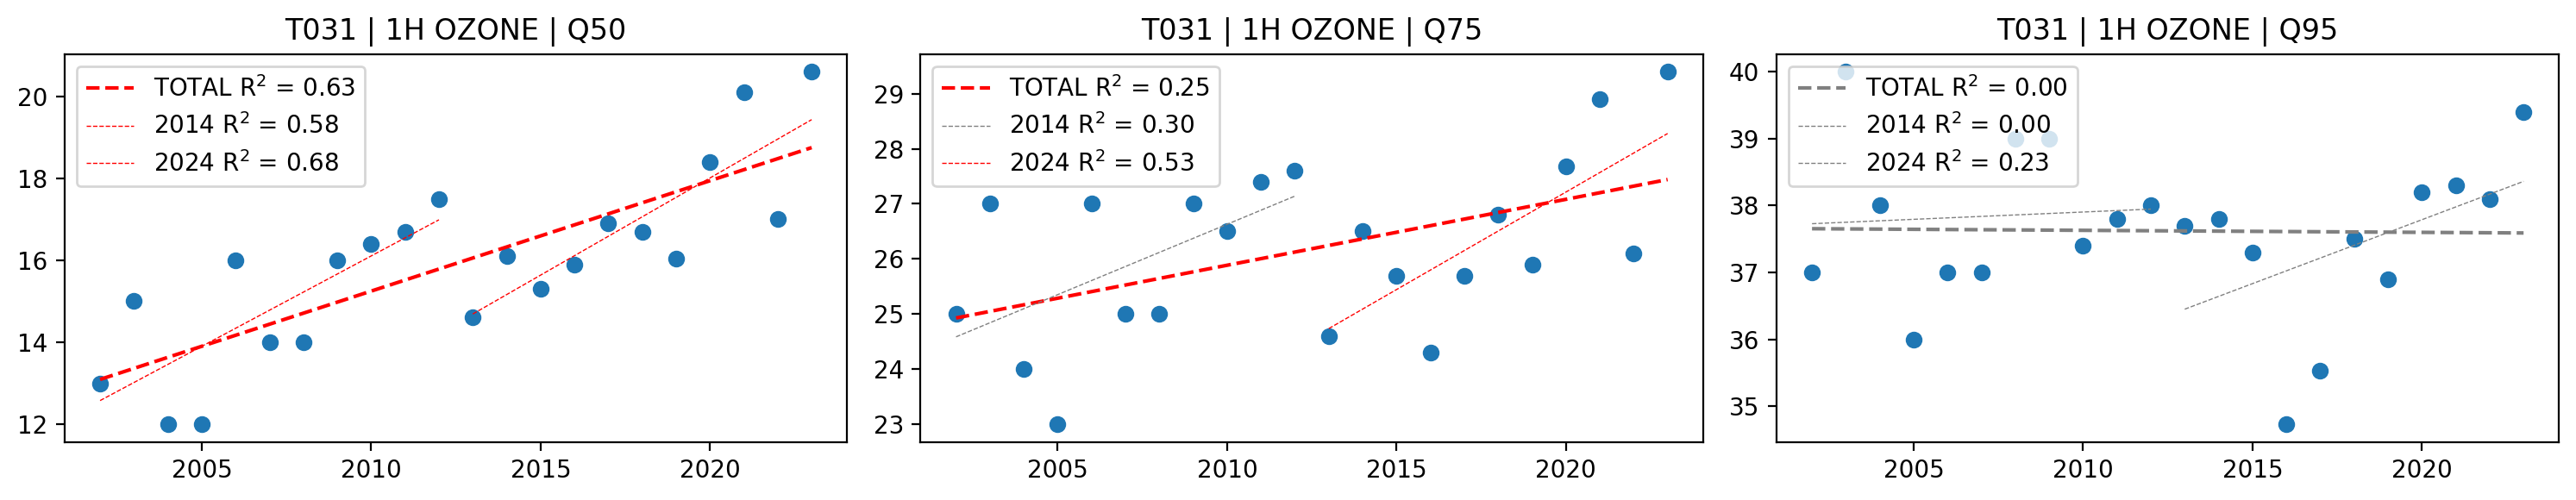

In [219]:
#-------------1H OZONE------------------
#loop through stations
for nStn, stn in enumerate(stations):

  #loop through quantiles
  numQnt = len(quantiles) + 1
  plt.figure(figsize=(5*numQnt,3))
  for nQ, qnt in enumerate(quantiles):

    #gather data
    # q = pd.concat([grp2014[stn].quantile(q=qnt), grp2024[stn].quantile(q=qnt)])
    q = grp_1h[stn].quantile(q=qnt)

    #------trendline------
    #add constant to predictor variables
    x = sm.add_constant(q.index.values)
    #fit linear regression model
    modelT = sm.OLS(q, x).fit()
    model2014 = sm.OLS(q[:11], x[:11]).fit()
    model2024 = sm.OLS(q[11:], x[11:]).fit()
    #get trend for last N years
    trendT = modelT.predict(exog=x)
    trend2014 = model2014.predict(exog=x[:11])
    trend2024 = model2024.predict(exog=x[11:])

    #----plotting-----
    plt.subplot(1,numQnt,nQ + 1)
    ax = plt.gca()
    plt.scatter(y = q, x=q.index)
    plt.plot(x[:,1],trendT,c=['red' if modelT.pvalues.x1<0.05 else 'gray'][0],linestyle='--',\
             label = f'TOTAL R$^2$ = {modelT.rsquared:0.2f}')
    plt.plot(x[:11,1],trend2014,c=['red' if model2014.pvalues.x1<0.05 else 'gray'][0],\
             linestyle='--', linewidth = 0.5, \
             label = f'2014 R$^2$ = {model2014.rsquared:0.2f}')
    plt.plot(x[11:,1],trend2024,c=['red' if model2024.pvalues.x1<0.05 else 'gray'][0],\
             linestyle='--', linewidth = 0.5, \
             label = f'2024 R$^2$ = {model2024.rsquared:0.2f}')
    plt.legend(loc=2)
    plt.title(f'{stn} | 1H OZONE | Q{int(qnt*100)}')
  plt.tight_layout()



In [192]:
grp2014.count()/8760

,T012,T031
Date & Time,,
2002,0.976142,0.970091
2003,0.977511,0.969635
2004,0.972945,0.965297
2005,0.978653,0.978425
2006,0.976712,0.979566
2007,0.974658,0.978425
2008,0.982192,0.980365
2009,0.976370,0.980822
2010,0.978196,0.980365


In [189]:
365*24

8760

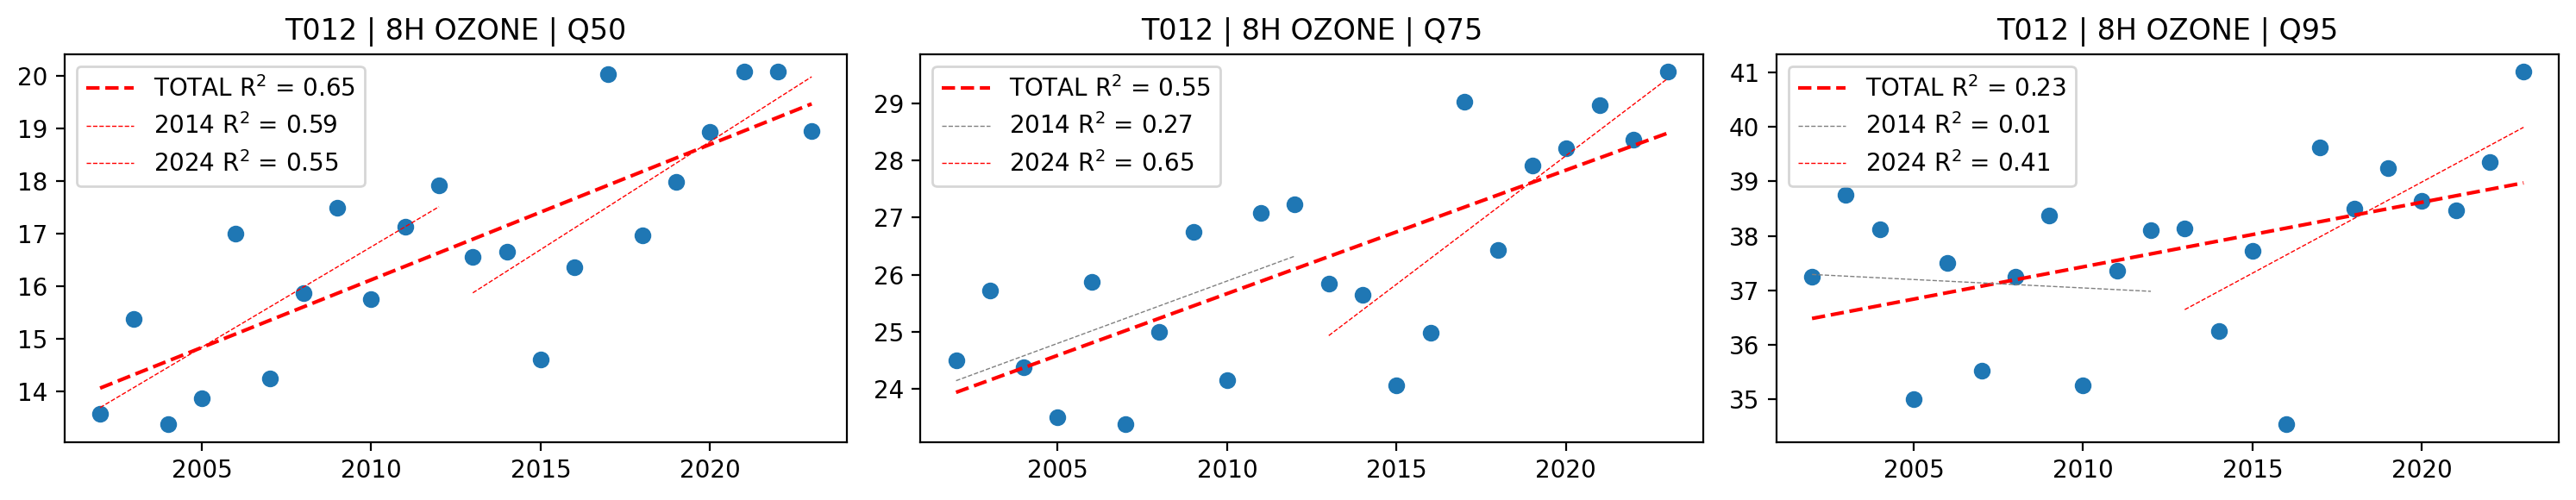

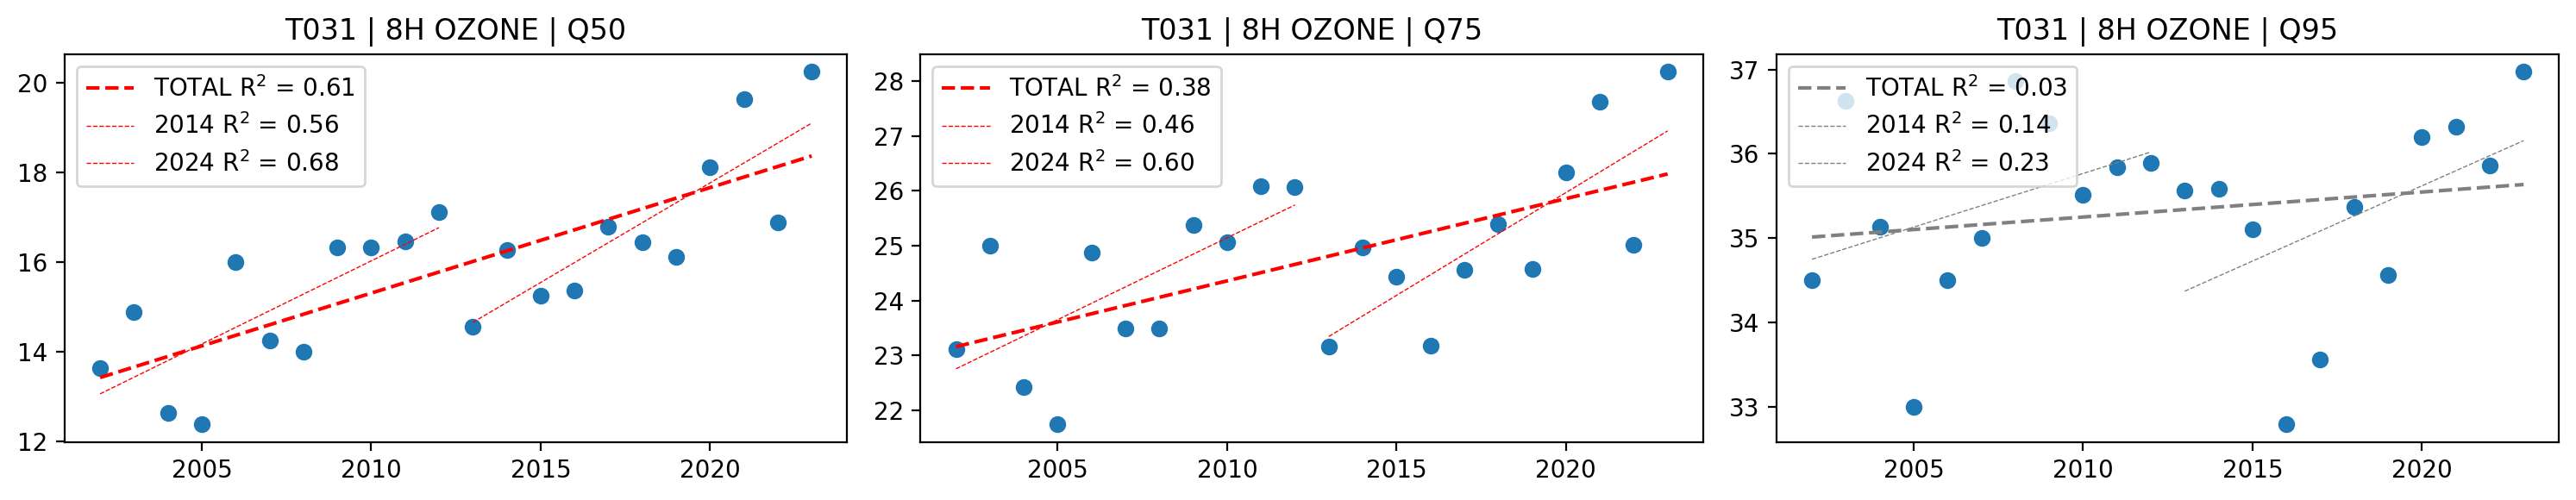

In [185]:
#-------------8H OZONE------------------
#loop through stations
for nStn, stn in enumerate(stations):

  #loop through quantiles
  numQnt = len(quantiles) + 1
  plt.figure(figsize=(5*numQnt,3))
  for nQ, qnt in enumerate(quantiles):

    #gather data
    q = pd.concat([grp8h2014[stn].quantile(q=qnt), grp8h2024[stn].quantile(q=qnt)])

    #------trendline------
    #add constant to predictor variables
    x = sm.add_constant(q.index.values)
    # x = sm.add_constant(q.index.values,has_constant='add')
    # x = q.index.values

    #fit linear regression model
    modelT = sm.OLS(q, x).fit()
    model2014 = sm.OLS(q[:11], x[:11]).fit()
    model2024 = sm.OLS(q[11:], x[11:]).fit()
    #get trend for last N years
    trendT = modelT.predict(exog=x)
    trend2014 = model2014.predict(exog=x[:11])
    trend2024 = model2024.predict(exog=x[11:])

    #----plotting-----
    plt.subplot(1,numQnt,nQ + 1)
    ax = plt.gca()
    plt.scatter(y = q, x=q.index)
    plt.plot(x[:,1],trendT,c=['red' if modelT.pvalues.x1<0.05 else 'gray'][0],linestyle='--',\
             label = f'TOTAL R$^2$ = {modelT.rsquared:0.2f}')
    plt.plot(x[:11,1],trend2014,c=['red' if model2014.pvalues.x1<0.05 else 'gray'][0],\
             linestyle='--', linewidth = 0.5, \
             label = f'2014 R$^2$ = {model2014.rsquared:0.2f}')
    plt.plot(x[11:,1],trend2024,c=['red' if model2024.pvalues.x1<0.05 else 'gray'][0],\
             linestyle='--', linewidth = 0.5, \
             label = f'2024 R$^2$ = {model2024.rsquared:0.2f}')
    plt.legend(loc=2)
    plt.title(f'{stn} | 8H OZONE | Q{int(qnt*100)}')
  plt.tight_layout()

In [ ]:
  # if (AveragingPeriod == '8hr'):
  #   # 8hr - loop through all points starting from the 8th
  #   for n in range(8,new_shape[0]):
  #     vals_in_8h = np.sum(~np.isnan(data[n-8:n]))  #get number of non-nans in a set
  #     if vals_in_8h > 5:                #CWS - must be more than 75%
  #       data_avg[n] = np.nansum(data[n-8:n])/vals_in_8h  #calculate average
  #     else:
  #       data_avg[n] = np.nan              #if less than 75% - set to nan
  #   # end loop over points


In [ ]:
TargetStnDct = {'O3':['T018','T013','T012','T017','T015','T026','T027','T029',\
                      'T009','T001','T002','T004','T006','TUS','TSAT','T033']}


In [ ]:



MV_stns = ['T009','T012','T014','T018','T026','T027','T029','T030','T031','T034/035','T043','T044']
EC_stns = ['T009','T012','T018','T026','T027','T029','T030','T031','T034/035'] #that overlap with

NOTES:

https://www2.gov.bc.ca/assets/gov/environment/air-land-water/air/reports-pub/prov_air_qual_objectives_fact_sheet.pdf
Ozone (O3)
1-hour  82 NAAQO9 1989
8-hour 62 2020 CAAQS* 2013

*https://gazette.gc.ca/rp-pr/p1/2013/2013-05-25/html/notice-avis-eng.html


Questions to consider:
Achievement based on annual 4th highest daily maximum 8-hour average concentration, averaged over three consecutive years. We originally excluded this with Bruce. Reconsider?
